# Textual inversion com Keras

Notebook baseado em:



*   https://keras.io/examples/generative/fine_tune_via_textual_inversion/
*   https://github.com/sayakpaul/dreambooth-keras/blob/main/src/dreambooth_trainer.py



## Instalando e atualizando bibliotecas

Iremos instalar a biblioteca KerasCV, da qual usaremos a implementação do Stable Diffusion. Além disso, iremos atualizar a biblioteca do Tensorflow e protobuf, para evitar problemas de inicialização.

In [ ]:
!pip install -q keras_cv==0.4.0
!pip install -q -U tensorflow
!pip install -q -U protobuf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.3/595.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 10.3 MB/s eta 0:00:00


## Importando as bibliotecas

In [ ]:
import math
import random

import keras_cv
import numpy as np
import tensorflow as tf
from keras_cv import layers as cv_layers
from keras_cv.models.stable_diffusion import NoiseScheduler
from tensorflow import keras
import matplotlib.pyplot as plt

## Funções úteis

*   __plot_image__: Função que imprime a imagem no notebook;
*   __pad_embedding__: Função que preenche a quantidade de tokens até o valor de contexto máximo (77, no caso).

In [ ]:
def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

def pad_embedding(embedding):
    return embedding + (
        [stable_diffusion.tokenizer.end_of_text] * (MAX_PROMPT_LENGTH - len(embedding))
    )

## Funções de criação do dataset

*   __assemble_image_dataset__: Função que recebe uma lista de arquivos, realiza *data augmentation* e cria um TF Dataset;
*   __assemble_text_dataset__: Função que recebe uma lista de prompts e o novo token do objeto/estilo a ser aprendido, e tokeniza os inputs;
*   __assemble_dataset__: Cria pares de imagem e prompt, para serem usados no treinamento.

In [ ]:
def assemble_image_dataset(file_paths, size):
    # Resize images
    resize = keras.layers.Resizing(height=size, width=size, crop_to_aspect_ratio=True)
    images = [keras.utils.load_img(img) for img in file_paths]
    images = [keras.utils.img_to_array(img) for img in images]
    images = np.array([resize(img) for img in images])

    # The StableDiffusion image encoder requires images to be normalized to the
    # [-1, 1] pixel value range
    images = images / 127.5 - 1

    # Create the tf.data.Dataset
    image_dataset = tf.data.Dataset.from_tensor_slices(images)

    # Shuffle and introduce random noise
    image_dataset = image_dataset.shuffle(50, reshuffle_each_iteration=True)
    image_dataset = image_dataset.map(
        cv_layers.RandomCropAndResize(
            target_size=(512, 512),
            crop_area_factor=(0.8, 1.0),
            aspect_ratio_factor=(1.0, 1.0),
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    image_dataset = image_dataset.map(
        cv_layers.RandomFlip(mode="horizontal"),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    return image_dataset


def assemble_text_dataset(prompts, placeholder_token):
    prompts = [prompt.format(placeholder_token) for prompt in prompts]
    embeddings = [stable_diffusion.tokenizer.encode(prompt) for prompt in prompts]
    embeddings = [np.array(pad_embedding(embedding)) for embedding in embeddings]
    text_dataset = tf.data.Dataset.from_tensor_slices(embeddings)
    return text_dataset


def assemble_dataset(file_paths, placeholder_token, prompts, size):
    image_dataset = assemble_image_dataset(file_paths, size)
    text_dataset = assemble_text_dataset(prompts, placeholder_token)

    image_dataset = image_dataset.repeat()
    text_dataset = text_dataset.repeat(5)
    return tf.data.Dataset.zip((image_dataset, text_dataset))

## Classe para treinar Textual Inversion

Definição da classe **TextualInversionFineTuner**, a qual é uma subclasse do *keras.Model* que sobrescreve o método *train_step* para treinar o embedding do novo token adicionado no *text encoder*.

Antes do treinamento, recriamos o *text encoder* com o novo token adicionado e inicializamos ele com base no "subject" enviado pelo usuário. O "subject" pode ser entendido como uma classe principal ao qual o objeto pertence.

De forma simplista, o processo de treinamento se dá da seguinte forma:

1.   Pegamos uma das imagens de treinamento, passamos em um *image encoder* para obter o embedding dessa imagem;
2.   Adicionamos ruído nesse embedding, com base em um timestep aleatório;
3.   Chamamos o modelo de difusão para prever o ruído usando como entrada o embedding ruidoso do passo acima;
4.   Calculamos a loss entre o ruído adicionado e o ruído predito.



In [ ]:
class TextualInversionFineTuner(keras.Model):
    def __init__(self, stable_diffusion, noise_scheduler, placeholder_token, subject="sks", **kwargs):
        super().__init__(**kwargs)
        self.stable_diffusion = stable_diffusion
        self.noise_scheduler = noise_scheduler

        self._add_new_token(placeholder_token, subject)

        self.training_image_encoder = keras.Model(
            stable_diffusion.image_encoder.input,
            stable_diffusion.image_encoder.layers[-2].output,
        )

    def _traverse_layers(self, layer):
      if hasattr(layer, "layers"):
          for layer in layer.layers:
              yield layer
      if hasattr(layer, "token_embedding"):
          yield layer.token_embedding
      if hasattr(layer, "position_embedding"):
          yield layer.position_embedding


    def _add_new_token(self, placeholder_token, subject):
        tokenized_initializer = self.stable_diffusion.tokenizer.encode(subject)[1]  # Inicializando com um token raro
        new_weights = self.stable_diffusion.text_encoder.layers[2].token_embedding(
            tf.constant(tokenized_initializer)
        )

        # Novo tamanho do vocabulario
        new_vocab_size = len(self.stable_diffusion.tokenizer.vocab)

        # A camada de embedding é a layer de indice 2
        old_token_weights = self.stable_diffusion.text_encoder.layers[
            2
        ].token_embedding.get_weights()
        old_position_weights = self.stable_diffusion.text_encoder.layers[
            2
        ].position_embedding.get_weights()

        old_token_weights = old_token_weights[0]
        new_weights = np.expand_dims(new_weights, axis=0)
        new_weights = np.concatenate([old_token_weights, new_weights], axis=0)

        # Have to set download_weights False so we can init (otherwise tries to load weights)
        new_encoder = keras_cv.models.stable_diffusion.TextEncoder(
            keras_cv.models.stable_diffusion.stable_diffusion.MAX_PROMPT_LENGTH,
            vocab_size=new_vocab_size,
            download_weights=False,
        )
        for index, layer in enumerate(self.stable_diffusion.text_encoder.layers):
            # Layer 2 is the embedding layer, so we omit it from our weight-copying
            if index == 2:
                continue
            new_encoder.layers[index].set_weights(layer.get_weights())


        new_encoder.layers[2].token_embedding.set_weights([new_weights])
        new_encoder.layers[2].position_embedding.set_weights(old_position_weights)

        self.stable_diffusion._text_encoder = new_encoder
        self.stable_diffusion._text_encoder.compile(jit_compile=True)

        self.stable_diffusion.diffusion_model.trainable = False
        self.stable_diffusion.decoder.trainable = False
        self.stable_diffusion.text_encoder.trainable = True

        self.stable_diffusion.text_encoder.layers[2].trainable = True

        for layer in self._traverse_layers(self.stable_diffusion.text_encoder):
          if isinstance(layer, keras.layers.Embedding) or "clip_embedding" in layer.name:
              layer.trainable = True
          else:
              layer.trainable = False
        
        new_encoder.layers[2].position_embedding.trainable = False


    def sample_from_encoder_outputs(self, outputs):
        mean, logvar = tf.split(outputs, 2, axis=-1)
        logvar = tf.clip_by_value(logvar, -30.0, 20.0)
        std = tf.exp(0.5 * logvar)
        sample = tf.random.normal(tf.shape(mean))
        return mean + std * sample


    def get_timestep_embedding(self, timestep, dim=320, max_period=10000):
        half = dim // 2
        freqs = tf.math.exp(
            -math.log(max_period) * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        return embedding


    def get_position_ids(self):
        return tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)


    def train_step(self, data):
        images, embeddings = data

        with tf.GradientTape() as tape:
            # Sample from the predicted distribution for the training image
            latents = self.sample_from_encoder_outputs(self.training_image_encoder(images))
            # The latents must be downsampled to match the scale of the latents used
            # in the training of StableDiffusion.  This number is truly just a "magic"
            # constant that they chose when training the model.
            latents = latents * 0.18215

            # Produce random noise in the same shape as the latent sample
            noise = tf.random.normal(tf.shape(latents))
            batch_dim = tf.shape(latents)[0]

            # Pick a random timestep for each sample in the batch
            timesteps = tf.random.uniform(
                (batch_dim,),
                minval=0,
                maxval=noise_scheduler.train_timesteps,
                dtype=tf.int64,
            )

            # Add noise to the latents based on the timestep for each sample
            noisy_latents = self.noise_scheduler.add_noise(latents, noise, timesteps)

            # Encode the text in the training samples to use as hidden state in the
            # diffusion model
            encoder_hidden_state = self.stable_diffusion.text_encoder(
                [embeddings, self.get_position_ids()]
            )

            # Compute timestep embeddings for the randomly-selected timesteps for each
            # sample in the batch
            timestep_embeddings = tf.map_fn(
                fn=self.get_timestep_embedding,
                elems=timesteps,
                fn_output_signature=tf.float32,
            )

            # Call the diffusion model
            noise_pred = self.stable_diffusion.diffusion_model(
                [noisy_latents, timestep_embeddings, encoder_hidden_state]
            )

            # Compute the mean-squared error loss and reduce it.
            loss = self.compiled_loss(noise_pred, noise)
            loss = tf.reduce_mean(loss, axis=2)
            loss = tf.reduce_mean(loss, axis=1)
            loss = tf.reduce_mean(loss)

        # Load the trainable weights and compute the gradients for them
        trainable_weights = self.stable_diffusion.text_encoder.trainable_weights
        grads = tape.gradient(loss, trainable_weights)

        index_of_placeholder_token = tf.reshape(tf.where(grads[0].indices == 49408), ())
        condition = grads[0].indices == 49408
        condition = tf.expand_dims(condition, axis=-1)

        # Override the gradients, zeroing out the gradients for all slices that
        # aren't for the placeholder token, effectively freezing the weights for
        # all other tokens.
        grads[0] = tf.IndexedSlices(
            values=tf.where(condition, grads[0].values, 0),
            indices=grads[0].indices,
            dense_shape=grads[0].dense_shape,
        )

        self.optimizer.apply_gradients(zip(grads, trainable_weights))
        return {"loss": loss}

## Treinamento



### Parâmetros de treino

In [ ]:
MAX_PROMPT_LENGTH = 77
EPOCHS = 50
placeholder_token = "espositope"
subject = "cat"

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


1

### Inicializando modelo base e testando resultado sem treino

Como o novo token será inicializado com o embedding do subject, testamos a geração de imagem com o subject para vermos a diferença no final do treino.

In [ ]:
stable_diffusion = keras_cv.models.StableDiffusion()
stable_diffusion.tokenizer.add_tokens(placeholder_token)

generated = stable_diffusion.text_to_image(
    f"an oil painting of {subject}", seed=1337, batch_size=1
)
plot_images(generated)

### Criando o dataset

Aqui, passamos os caminhos das imagens que iremos usar, o token que estamos adicionando, e uma lista com variações de prompts a fim de aumentar nossa base de treino e ter certa variância.

In [ ]:
train_ds = assemble_dataset(
    file_paths=["/content/cat1.jpg",
                "/content/cat2.jpeg",
                "/content/cat3.jpeg",
                "/content/cat4.jpeg",
                "/content/cat5.jpeg"],
    placeholder_token=placeholder_token,
    prompts=[
        "a photo of a {}",
        "a rendering of a {}",
        "a cropped photo of the {}",
        "the photo of a {}",
        "a photo of a clean {}",
        "a photo of my {}",
        "a photo of the cool {}",
        "a close-up photo of a {}",
        "a bright photo of the {}",
        "a cropped photo of a {}",
        "a photo of the {}",
        "a good photo of the {}",
        "a photo of one {}",
        "a close-up photo of the {}",
        "a rendition of the {}",
        "a photo of the clean {}",
        "a rendition of a {}",
        "a photo of a nice {}",
        "a good photo of a {}",
        "a photo of the nice {}",
        "a photo of the small {}",
        "a photo of the weird {}",
        "a photo of the large {}",
        "a photo of a cool {}",
        "a photo of a small {}",
    ],
    size=512
)

train_ds = train_ds.batch(1).shuffle(
    train_ds.cardinality(), reshuffle_each_iteration=True
)

### Definindo otimizador e noise_scheduler

In [ ]:
noise_scheduler = NoiseScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    train_timesteps=1000,
)

learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4, decay_steps=train_ds.cardinality() * EPOCHS
)

optimizer = keras.optimizers.Adam(
    weight_decay=0.004, learning_rate=learning_rate, epsilon=1e-8, global_clipnorm=10
)

### Instanciando classe de treinamento

In [ ]:
trainer = TextualInversionFineTuner(stable_diffusion, noise_scheduler,
                                    placeholder_token, subject=subject,
                                    name="trainer")

trainer.compile(
    optimizer=optimizer,
    # We are performing reduction manually in our train step, so none is required here.
    loss=keras.losses.MeanSquaredError(reduction="none"),
)

[[TensorShape([49409, 768])], [], []]


In [ ]:
class GenerateImages(keras.callbacks.Callback):
    def __init__(
        self, stable_diffusion, prompt, steps=25, frequency=20, seed=None, **kwargs
    ):
        super().__init__(**kwargs)
        self.stable_diffusion = stable_diffusion
        self.prompt = prompt
        self.seed = seed
        self.frequency = frequency
        self.steps = steps

    def on_epoch_end(self, epoch, logs):
        if epoch % self.frequency == 0:
            images = self.stable_diffusion.text_to_image(
                self.prompt, batch_size=1, num_steps=self.steps, seed=self.seed
            )
            plot_images(
                images,
            )


cbs = [
    GenerateImages(
        stable_diffusion, prompt=f"an oil painting of {placeholder_token}", seed=1337
    ),
    GenerateImages(
        stable_diffusion, prompt=f"a {placeholder_token} stamp", seed=1337
    )
]

Bora treinar!!!

In [ ]:
trainer.fit(
    train_ds,
    epochs=50,
    callbacks=cbs,
)

Epoch 1/50
125/125 [==============================] - 114s 260ms/step - loss: 0.0825
Epoch 2/50
125/125 [==============================] - 32s 253ms/step - loss: 0.0876
Epoch 3/50
125/125 [==============================] - 32s 253ms/step - loss: 0.1035
Epoch 4/50
125/125 [==============================] - 32s 253ms/step - loss: 0.1057
Epoch 5/50
125/125 [==============================] - 32s 253ms/step - loss: 0.1050
Epoch 6/50
125/125 [==============================] - 32s 255ms/step - loss: 0.0947
Epoch 7/50
125/125 [==============================] - 32s 254ms/step - loss: 0.1042
Epoch 8/50
125/125 [==============================] - 32s 253ms/step - loss: 0.0969
Epoch 9/50
125/125 [==============================] - 32s 254ms/step - loss: 0.0880
Epoch 10/50
125/125 [==============================] - 32s 253ms/step - loss: 0.1066
Epoch 11/50
125/125 [==============================] - 32s 253ms/step - loss: 0.0872
Epoch 12/50
125/125 [==============================] - 32s 253ms/step - l

KeyboardInterrupt: ignored

## Realizando inferência

Com o novo token adicionado e o embedding aprendido, podemos realizar a inferência e ver os resultados!

50/50 [==============================] - 17s 347ms/step


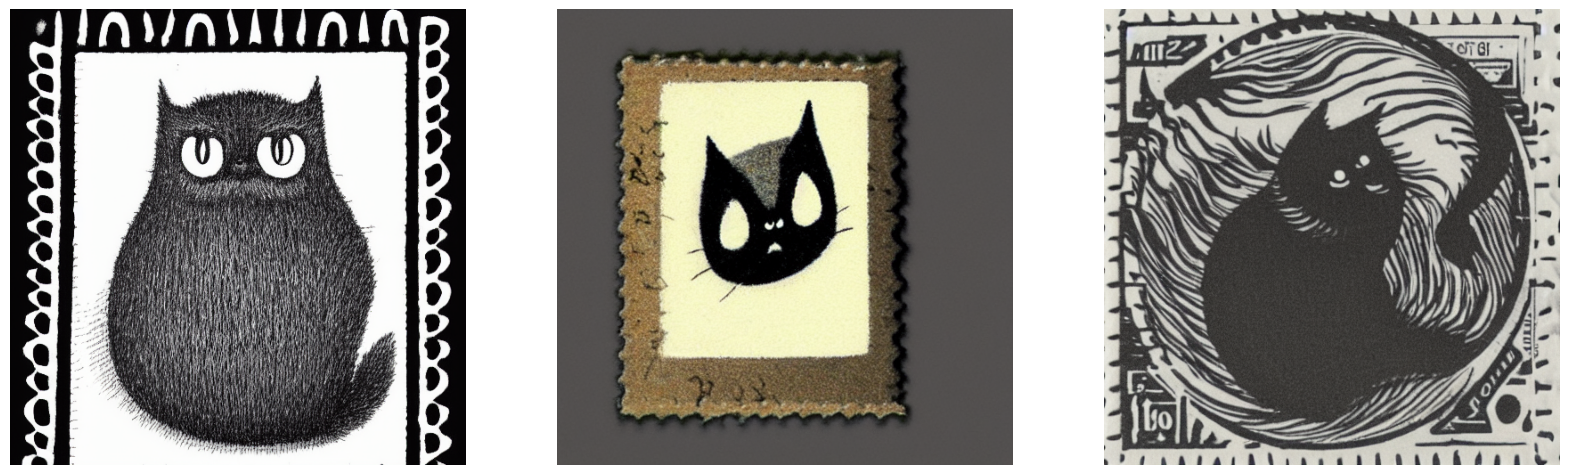

In [ ]:
generated = trainer.stable_diffusion.text_to_image(
    f"a {placeholder_token} stamp",
    batch_size=3,
    num_steps=50
)
plot_images(generated)